In [932]:
import pandas as pd
import math
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator
import matplotlib.ticker as ticker

%matplotlib inline

## Reading in Game of Thrones' subtitles

In [933]:
filenames = glob.glob("Got_s01_s07_subs/*/*.srt")
filenames[:5]

['Got_s01_s07_subs/s01/1x01 - Winter is Coming.srt',
 'Got_s01_s07_subs/s01/1x02 - The Kingsroad.srt',
 'Got_s01_s07_subs/s01/1x03 - Lord Snow.srt',
 'Got_s01_s07_subs/s01/1x04 - Cripples  Bastards  and Broken Things.srt',
 'Got_s01_s07_subs/s01/1x05 - The Wolf and the Lion.srt']

In [934]:
got_episodes = []

for filename in filenames:
    got_episodes.append({
        'content': open(filename).read(),
        'filename': filename,
        'title': re.search(r'(?<=- ).*(?=\.)', filename)[0],
        'season': int(re.search(r'\d(?=x)', filename)[0]),
        'episode': int(re.search(r'(?<=x)\d\d', filename)[0])
    })

got_episodes_df = pd.DataFrame(got_episodes)
got_episodes_df.head(3)

,content,episode,filename,season,title
0,"1\n00:01:55,418 --> 00:01:58,420\nEasy, boy.\n...",1,Got_s01_s07_subs/s01/1x01 - Winter is Coming.srt,1,Winter is Coming
1,"﻿1\n00:00:04,652 --> 00:00:06,681\nThere was a...",2,Got_s01_s07_subs/s01/1x02 - The Kingsroad.srt,1,The Kingsroad
2,"﻿1\n00:00:00,727 --> 00:00:02,930\nStill not f...",3,Got_s01_s07_subs/s01/1x03 - Lord Snow.srt,1,Lord Snow


## Reading in Game of Thrones' episodes length

In [935]:
got_len = pd.read_csv('episodes_length.csv')
got_len.head()

,Season,Episode,Length
0,1,1,61
1,1,2,55
2,1,3,57
3,1,4,55
4,1,5,54


## Extract the dialogues timestamps

In [936]:
dialogues_refined = []

for index, episode in got_episodes_df.iterrows():
    for dialogue in re.compile("\n\n").split(episode['content']):
        if len(re.findall('font color', dialogue)) == 0:
            for time in re.findall('(\d\d:\d\d:\d\d,\d\d\d) --> (\d\d:\d\d:\d\d,\d\d\d)', dialogue):
                dialogues_refined.append({
                    'start': pd.to_datetime(time[0] + '000', format='%H:%M:%S,%f'),
                    'end': pd.to_datetime(time[1] + '000', format='%H:%M:%S,%f'),
                    'episode': episode['episode'],
                    'season': episode['season'],
                    'title': episode['title'],
                })
                
dialogues_refined = pd.DataFrame(dialogues_refined)

In [937]:
dialogues_refined.head()

,end,episode,season,start,title
0,1900-01-01 00:01:58.420,1,1,1900-01-01 00:01:55.418,Winter is Coming
1,1900-01-01 00:02:56.881,1,1,1900-01-01 00:02:55.047,Winter is Coming
2,1900-01-01 00:03:13.331,1,1,1900-01-01 00:03:11.162,Winter is Coming
3,1900-01-01 00:03:15.700,1,1,1900-01-01 00:03:13.365,Winter is Coming
4,1900-01-01 00:03:18.737,1,1,1900-01-01 00:03:15.734,Winter is Coming


## Plot the dialogues

In [938]:
def make_graph(episode_df, limits):
    # Which episode 
    season_id = episode_df['season'].head(1).item()
    episode_id = episode_df['episode'].head(1).item()
    
    # Get the full length of this episode
    episode_length = got_len[
        (got_len['Episode'] == episode_id) 
        & (got_len['Season'] == season_id)]['Length'].item()
    end_hour = '{0:02d}'.format(math.floor(episode_length / 60))
    end_min = '{0:02d}'.format(episode_length % 60)
    
    # Prepare the graph
    plt.subplot(15, 1, episode_id)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().xaxis_date()
    plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
    if limits: plt.gca().set_xlim(limits['start'], limits['end'])
    
    # Plot the dialogues
    for index, line in episode_df.iterrows():
        plt.hlines(0, line.start, line.end, '#a20d7d', alpha=1, lw=10)

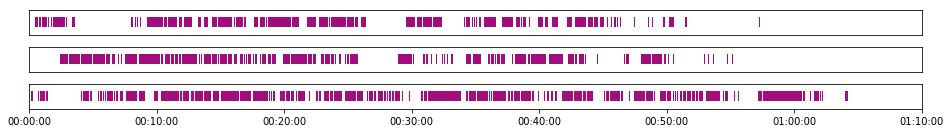

In [1045]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=.5)
dialogues_refined[dialogues_refined['season'] == 7].groupby('episode').apply(make_graph, {
    'start':pd.Timestamp('1900-01-01 00:00:00.000'),
    'end':pd.Timestamp('1900-01-01 01:10:00.000')})
plt.gca().axes.get_xaxis().set_visible(True)

## Save the graphs to pdf

""


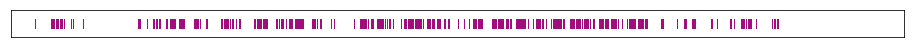

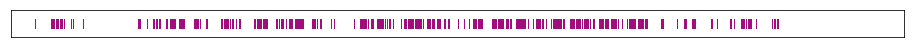

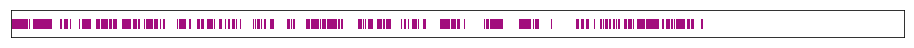

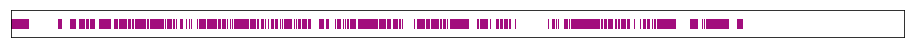

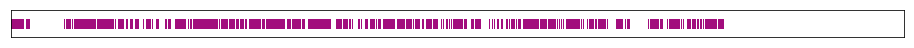

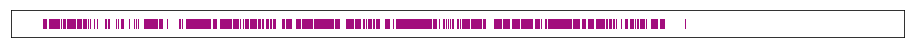

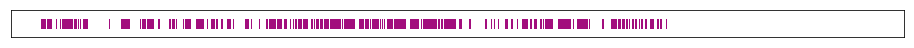

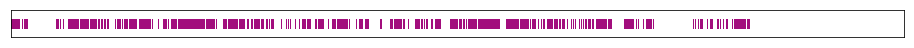

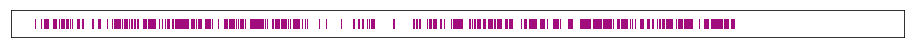

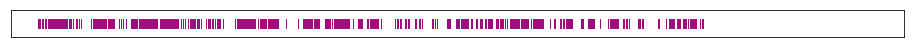

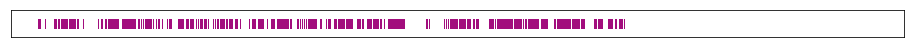

In [940]:
def save_graph(episode_df):
    plt.figure(figsize=(16, .5))
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().set_xlim(
        pd.Timestamp('1900-01-01 00:00:00.000'),
        pd.Timestamp('1900-01-01 01:10:00.000'))

    for index, line in episode_df.iterrows():
        plt.hlines(0, line.start, line.end, '#a20d7d', alpha=1, lw=10)
        
    season_id = episode_df['season'].head(1).item()
    episode_id = episode_df['episode'].head(1).item()
    plt.savefig('output/s' + str(season_id) + 'e' + '{0:02d}'.format(episode_id) + '.png')

    
dialogues_refined[dialogues_refined['season'] == 1].groupby('episode').apply(save_graph)

## Join the dialogues together to have a more readable score

In [1020]:
segments = []

for ep_index, ep in dialogues_refined.groupby(['season', 'episode']):
    last_d = pd.DataFrame()
    
    for index, d in ep.iterrows():
        if last_d.empty == False:
            # Seconds allowed to make a junction: 7s
            if d['start'] - last_d['end'] > pd.Timedelta(seconds=7):
                # new segment
                segment_end = last_d['end']    
                segments.append({
                    'start': segment_start,
                    'end': segment_end,
                    'episode': d['episode'],
                    'season': d['season'],
                    'title': d['title']
                })          
                segment_start = d['start']
        else:
            segment_start = d['start']
        last_d = d
    
segments = pd.DataFrame(segments)

## Plot and compare the adjusted version with the original one

In [1080]:
# Values used for testing
test_values = {
    'limit_start': pd.Timestamp('1900-01-01 00:00:00.000'),
    'limit_end': pd.Timestamp('1900-01-01 01:10:00.000'),
    'season': 4,
    'episode': 9
}

### Original score

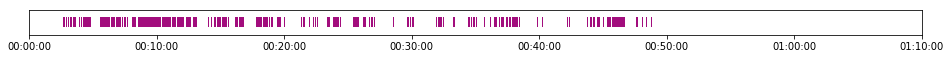

In [1081]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=.5)
make_graph(
    dialogues_refined[
        (dialogues_refined['season'] == test_values['season'])
        &(dialogues_refined['episode'] == test_values['episode'])],
    {
        'start': test_values['limit_start'],
        'end': test_values['limit_end']
    })
plt.gca().axes.get_xaxis().set_visible(True)

### Joined dialogues score

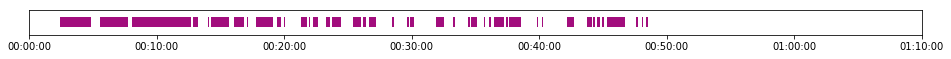

In [1082]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=.5)
make_graph(
    segments[
        (segments['season'] == test_values['season'])
        &(segments['episode'] == test_values['episode'])],
    {
        'start': test_values['limit_start'],
        'end': test_values['limit_end']
    })
plt.gca().axes.get_xaxis().set_visible(True)

### Without the isolated short dialogues

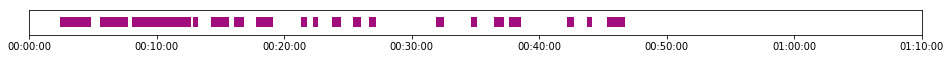

In [1083]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=.5)
make_graph(
    segments[
        (segments['end'] - segments['start'] > pd.Timedelta(seconds=20))
        &(segments['season'] == test_values['season'])
        &(segments['episode'] == test_values['episode'])],
    {
        'start': test_values['limit_start'],
        'end': test_values['limit_end']
    })
plt.gca().axes.get_xaxis().set_visible(True)

## Fit the score into a grid of n segments of the same length

In [1084]:
def format_timedelta(td):
    minutes, seconds = divmod(td.seconds + td.days * 86400, 60)
    hours, minutes = divmod(minutes, 60)
    return '{:d}:{:02d}:{:02d}'.format(hours, minutes, seconds)

In [1085]:
cells_number = 12
limits = {
    'start': pd.Timestamp('1900-01-01 00:00:00.000'),
    'end': pd.Timestamp('1900-01-01 01:00:00.000')
}
cell_length = limits['end'] - limits['start']
cell_length = cell_length / cells_number

Cell - 0 - filed at 0:02:26 remain: 0:00:00
Cell - 1 - filed at 0:04:05 remain: 0:02:40
Cell - 2 - filed at 0:03:28 remain: 0:00:40
Cell - 3 - filed at 0:02:46 remain: 0:00:00
Cell - 4 - filed at 0:01:13 remain: 0:00:00
Cell - 5 - filed at 0:01:14 remain: 0:00:00
Cell - 6 - filed at 0:00:36 remain: 0:00:00
Cell - 7 - filed at 0:01:45 remain: 0:00:00
Cell - 8 - filed at 0:00:34 remain: 0:00:00
Cell - 9 - filed at 0:01:24 remain: 0:00:00
Cell - 10 - filed at 0:00:00 remain: 0:00:00
Cell - 11 - filed at 0:00:00 remain: 0:00:00


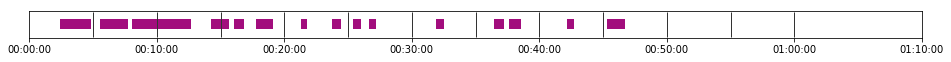

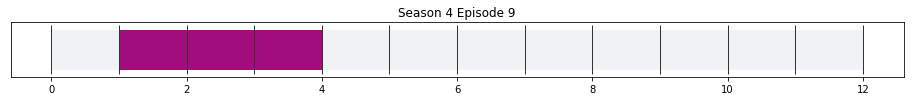

In [1086]:
segments_test = segments[
        (segments['end'] - segments['start'] > pd.Timedelta(seconds=30))
        &(segments['season'] == test_values['season'])
        &(segments['episode'] == test_values['episode'])].copy()

plt.figure(figsize=(16, .5))
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().set_xlim(
    pd.Timestamp('1900-01-01 00:00:00.000'),
    pd.Timestamp('1900-01-01 01:10:00.000'))

cells = []
remain = pd.Timedelta(seconds=0)

for ic in range(cells_number):
    
    current_cell_time['start'] = limits['start'] + ic * cell_length
    current_cell_time['end'] = current_cell_time['start'] + cell_length
    cell_fill = pd.Timedelta(seconds=0)
        
    if remain > pd.Timedelta(seconds=0):
        n_covered = math.floor(remain / cell_length)
        
        if n_covered > 0:
            for c in range(n_filled):
                cells.append(True)
                ic = ic + 1
            remain = remain % n_covered
            next
        
        cell_fill = cell_fill + remain
        remain = pd.Timedelta(seconds=0)
    
    for i, (index, s) in enumerate(segments_test.iterrows()):
        if ic==0:
            plt.hlines(0, s['start'], s['end'], '#a20d7d', alpha=1, lw=10)
        # If the current segment fit the cell
        if (s['start'] > current_cell_time['start']) & (s['end'] < current_cell_time['end']):
            s_length = s['end'] - s['start']
            cell_fill = cell_fill + s_length
        # If the current segment overlap the cell
        else:
            if (s['end'] > current_cell_time['end'])& (s['start'] < current_cell_time['end']):
                remain = s['end'] - current_cell_time['end']
                s['end'] = current_cell_time['end']
                s_length = s['end'] - s['start']
                cell_fill = cell_fill + s_length
    
    print("Cell -", ic, 
          "- filed at", format_timedelta(cell_fill), 
          "remain:", format_timedelta(remain))
    cells.append(True if cell_fill > pd.Timedelta(seconds=150) else False)
    plt.vlines(current_cell_time['start']+cell_length, -5, 5, '#333333', alpha=1, lw=1) 

plt.vlines(0, -5, 5, '#333333', alpha=1, lw=1) 
plt.figure(figsize=(16, 1))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: int(x/10)))
plt.title("Season "+ str(test_values['season']) + " Episode "+ str(test_values['episode']))
plt.gca().axes.get_yaxis().set_visible(False)
plt.vlines(0, -20, 20, '#333333', alpha=1, lw=1, zorder=100)
for i, t in enumerate(cells):
    w = 10
    x = i*10 + i*0
    color = '#a20d7d' if t else '#f1f2f3'
    plt.hlines(0, x, x+w, color, alpha=1, lw=40)
    plt.vlines(x+w, -20, 20, '#333333', alpha=1, lw=1, zorder=100)

In [1179]:
def make_cells(episode_df, cells_number, fill_percentage):
    # Which episode 
    season_id = episode_df['season'].head(1).item()
    episode_id = episode_df['episode'].head(1).item()    

    # Initialize the graph
    limits = {
        'start': pd.Timestamp('1900-01-01 00:00:00.000'),
        'end': pd.Timestamp('1900-01-01 01:00:00.000')
    }
    cell_length = limits['end'] - limits['start']
    cell_length = cell_length / cells_number
    cells = []
    remain = pd.Timedelta(seconds=0)    
    
    # Draw each cell
    for ic in range(cells_number):
        
        # Initialize the cell
        current_cell_time['start'] = limits['start'] + ic * cell_length
        current_cell_time['end'] = current_cell_time['start'] + cell_length
        cell_fill = pd.Timedelta(seconds=0)

        if remain > pd.Timedelta(seconds=0):
            n_covered = math.floor(remain / cell_length)

            if n_covered > 0:
                print(episode_id)
                for c in range(n_filled):
                    cells.append(True)
                    ic = ic + 1
                #remain = remain % n_covered
                next

            cell_fill = cell_fill + remain
            remain = pd.Timedelta(seconds=0)

        for i, (index, s) in enumerate(episode_df.iterrows()):
            # If the current segment fit the cell
            if (s['start'] > current_cell_time['start']) & (s['end'] < current_cell_time['end']):
                s_length = s['end'] - s['start']
                cell_fill = cell_fill + s_length
            # If the current segment overlap the cell
            else:
                if (s['end'] > current_cell_time['end'])& (s['start'] < current_cell_time['end']):
                    remain = s['end'] - current_cell_time['end']
                    s['end'] = current_cell_time['end']
                    s_length = s['end'] - s['start']
                    cell_fill = cell_fill + s_length

        cells.append(True if cell_fill/cell_length > fill_percentage else False)

    plt.subplot(15, 1, episode_id)
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: int(x/10)))
    plt.title("Season "+ str(season_id) + " Episode "+ str(episode_id))
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.vlines(0, -5, 5, '#333333', alpha=1, lw=1) 
    plt.vlines(0, -20, 20, '#333333', alpha=1, lw=1, zorder=100)
    
    for i, t in enumerate(cells):
        w = 10
        x = i*10 + i*0
        color = '#a20d7d' if t else '#f1f2f3'
        plt.hlines(0, x, x+w, color, alpha=1, lw=40)
        plt.vlines(x+w, -20, 20, '#333333', alpha=1, lw=1, zorder=100)

9


""


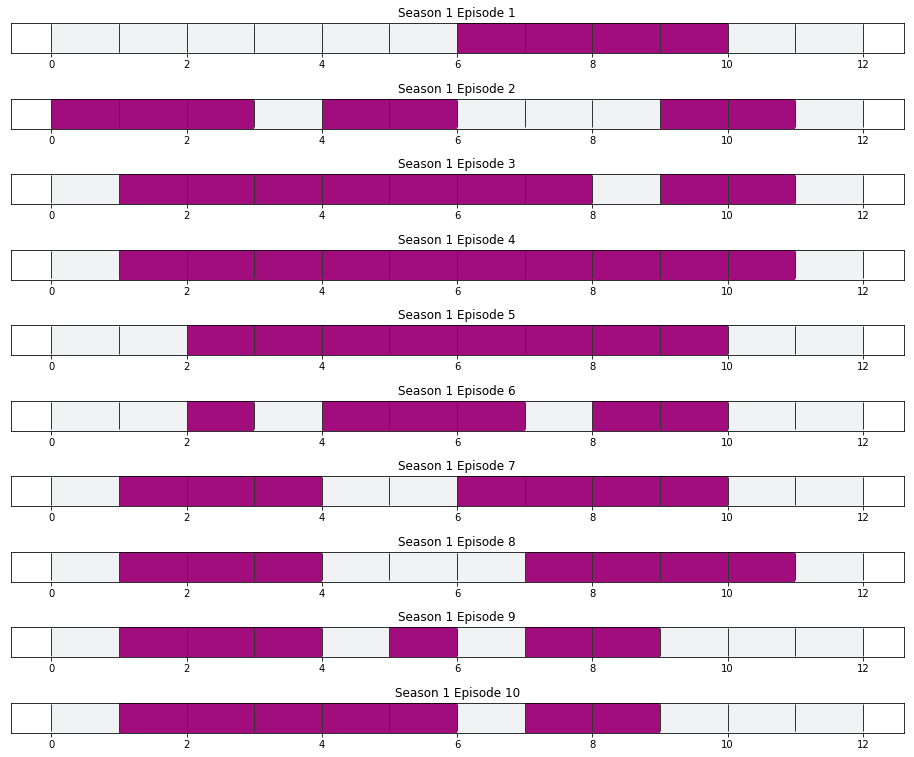

In [1180]:
plt.figure(figsize=(16, 20))
plt.subplots_adjust(hspace=1.5)

(segments[segments['season'] == 1]
 .groupby(['season', 'episode'])
 .apply(make_cells, 12, .6))

In [1115]:
def find_cell_by_time(time):
    return math.floor((time - pd.Timestamp('1900-01-01 00:00:00.000')) / cell_length)

In [1123]:
find_cell_by_time(pd.Timestamp('1900-01-01 00:10:20.000'))

2

In [1174]:
blank_segments = []

for ep_index, ep in segments[segments['end'] - segments['start'] > pd.Timedelta(seconds=20)].groupby(['season', 'episode']):
    for i, (index, s) in enumerate(ep.iterrows()):
        print(s['start'], s['end'], i)
        if (i%2 != 0) & (i > 0):
            blank_seg_end = s['start']
            blank_segments.append({
                'start': blank_seg_start,
                'end': blank_seg_end,
                'episode': s['episode'],
                'season': s['season'],
                'title': s['title']
            })
            print(str(len(blank_segments)-1), blank_seg_start, blank_seg_end)
            blank_seg_start = s['end']
        else:
            blank_seg_start = s['end']
            
blank_segments = pd.DataFrame(blank_segments)

1900-01-01 00:03:11.162000 1900-01-01 00:04:13.260000 0
1900-01-01 00:09:48.161000 1900-01-01 00:10:14.455000 1
0 1900-01-01 00:04:13.260000 1900-01-01 00:09:48.161000
1900-01-01 00:11:03.173000 1900-01-01 00:11:45.810000 2
1900-01-01 00:12:30.924000 1900-01-01 00:12:56.183000 3
1 1900-01-01 00:11:45.810000 1900-01-01 00:12:30.924000
1900-01-01 00:13:13 1900-01-01 00:13:38.125000 4
1900-01-01 00:14:22.236000 1900-01-01 00:14:53.868000 5
2 1900-01-01 00:13:38.125000 1900-01-01 00:14:22.236000
1900-01-01 00:16:29.003000 1900-01-01 00:17:30.462000 6
1900-01-01 00:19:04.654000 1900-01-01 00:20:10.017000 7
3 1900-01-01 00:17:30.462000 1900-01-01 00:19:04.654000
1900-01-01 00:20:48.324000 1900-01-01 00:21:39.410000 8
1900-01-01 00:21:49.154000 1900-01-01 00:22:09.242000 9
4 1900-01-01 00:21:39.410000 1900-01-01 00:21:49.154000
1900-01-01 00:22:17.952000 1900-01-01 00:23:00.963000 10
1900-01-01 00:23:37.868000 1900-01-01 00:24:24.914000 11
5 1900-01-01 00:23:00.963000 1900-01-01 00:23:37.8680

164 1900-01-01 00:01:56.896000 1900-01-01 00:02:15.648000
1900-01-01 00:03:52.663000 1900-01-01 00:05:05.070000 2
1900-01-01 00:05:18.151000 1900-01-01 00:07:45.228000 3
165 1900-01-01 00:05:05.070000 1900-01-01 00:05:18.151000
1900-01-01 00:08:13.459000 1900-01-01 00:09:37.641000 4
1900-01-01 00:09:45.850000 1900-01-01 00:11:03.496000 5
166 1900-01-01 00:09:37.641000 1900-01-01 00:09:45.850000
1900-01-01 00:11:11.838000 1900-01-01 00:11:54.948000 6
1900-01-01 00:12:10.799000 1900-01-01 00:13:00.782000 7
167 1900-01-01 00:11:54.948000 1900-01-01 00:12:10.799000
1900-01-01 00:13:08.491000 1900-01-01 00:14:17.828000 8
1900-01-01 00:14:57.905000 1900-01-01 00:15:31.071000 9
168 1900-01-01 00:14:17.828000 1900-01-01 00:14:57.905000
1900-01-01 00:15:54.996000 1900-01-01 00:16:45.677000 10
1900-01-01 00:16:54.519000 1900-01-01 00:18:37.518000 11
169 1900-01-01 00:16:45.677000 1900-01-01 00:16:54.519000
1900-01-01 00:18:55.203000 1900-01-01 00:20:28.600000 12
1900-01-01 00:21:45.146000 1900-0

301 1900-01-01 00:21:55.630000 1900-01-01 00:23:01.698000
1900-01-01 00:24:40.227000 1900-01-01 00:25:35.852000 12
1900-01-01 00:26:00.878000 1900-01-01 00:26:30.673000 13
302 1900-01-01 00:25:35.852000 1900-01-01 00:26:00.878000
1900-01-01 00:27:11.083000 1900-01-01 00:28:02.969000 14
1900-01-01 00:28:15.083000 1900-01-01 00:30:39.125000 15
303 1900-01-01 00:28:02.969000 1900-01-01 00:28:15.083000
1900-01-01 00:31:17.500000 1900-01-01 00:32:20.264000 16
1900-01-01 00:32:30.743000 1900-01-01 00:33:56.695000 17
304 1900-01-01 00:32:20.264000 1900-01-01 00:32:30.743000
1900-01-01 00:34:04.472000 1900-01-01 00:34:33.332000 18
1900-01-01 00:36:09.930000 1900-01-01 00:36:35.852000 19
305 1900-01-01 00:34:33.332000 1900-01-01 00:36:09.930000
1900-01-01 00:36:45.663000 1900-01-01 00:43:33.077000 20
1900-01-01 00:43:45.290000 1900-01-01 00:45:07.774000 21
306 1900-01-01 00:43:33.077000 1900-01-01 00:43:45.290000
1900-01-01 00:46:42.638000 1900-01-01 00:48:17.665000 22
1900-01-01 00:48:25.84000

451 1900-01-01 00:45:33.963000 1900-01-01 00:45:44.324000
1900-01-01 00:48:29.306000 1900-01-01 00:49:01.387000 24
1900-01-01 00:49:10.213000 1900-01-01 00:50:25.287000 25
452 1900-01-01 00:49:01.387000 1900-01-01 00:49:10.213000
1900-01-01 00:03:54.133000 1900-01-01 00:04:33.672000 0
1900-01-01 00:04:47.820000 1900-01-01 00:05:35.484000 1
453 1900-01-01 00:04:33.672000 1900-01-01 00:04:47.820000
1900-01-01 00:07:23.209000 1900-01-01 00:09:04.910000 2
1900-01-01 00:10:05.388000 1900-01-01 00:11:09.984000 3
454 1900-01-01 00:09:04.910000 1900-01-01 00:10:05.388000
1900-01-01 00:11:45.337000 1900-01-01 00:12:55.006000 4
1900-01-01 00:14:05.077000 1900-01-01 00:15:06.354000 5
455 1900-01-01 00:12:55.006000 1900-01-01 00:14:05.077000
1900-01-01 00:16:21.347000 1900-01-01 00:19:16.554000 6
1900-01-01 00:19:26.765000 1900-01-01 00:21:18.175000 7
456 1900-01-01 00:19:16.554000 1900-01-01 00:19:26.765000
1900-01-01 00:21:28.103000 1900-01-01 00:25:38.402000 8
1900-01-01 00:25:53.585000 1900-01

1900-01-01 00:45:25.401000 1900-01-01 00:46:19.052000 28
1900-01-01 00:49:14.222000 1900-01-01 00:49:41.948000 29
568 1900-01-01 00:46:19.052000 1900-01-01 00:49:14.222000
1900-01-01 00:50:15.114000 1900-01-01 00:51:51.340000 30
1900-01-01 00:52:43.758000 1900-01-01 00:56:07.722000 31
569 1900-01-01 00:51:51.340000 1900-01-01 00:52:43.758000
1900-01-01 00:01:45.532000 1900-01-01 00:05:08.686000 0
1900-01-01 00:05:21.166000 1900-01-01 00:06:22.060000 1
570 1900-01-01 00:05:08.686000 1900-01-01 00:05:21.166000
1900-01-01 00:07:33.098000 1900-01-01 00:09:33.618000 2
1900-01-01 00:10:19.498000 1900-01-01 00:12:24.121000 3
571 1900-01-01 00:09:33.618000 1900-01-01 00:10:19.498000
1900-01-01 00:13:13.271000 1900-01-01 00:15:36.513000 4
1900-01-01 00:16:11.716000 1900-01-01 00:19:43.126000 5
572 1900-01-01 00:15:36.513000 1900-01-01 00:16:11.716000
1900-01-01 00:19:50.969000 1900-01-01 00:21:37.941000 6
1900-01-01 00:21:45.550000 1900-01-01 00:25:00.944000 7
573 1900-01-01 00:21:37.941000 190

709 1900-01-01 00:01:35.037000 1900-01-01 00:01:43.788000
1900-01-01 00:07:56.579000 1900-01-01 00:08:33.329000 2
1900-01-01 00:09:13.995000 1900-01-01 00:11:57.203000 3
710 1900-01-01 00:08:33.329000 1900-01-01 00:09:13.995000
1900-01-01 00:12:10.412000 1900-01-01 00:12:50.746000 4
1900-01-01 00:13:38.788000 1900-01-01 00:13:59.161000 5
711 1900-01-01 00:12:50.746000 1900-01-01 00:13:38.788000
1900-01-01 00:14:18.287000 1900-01-01 00:15:52.704000 6
1900-01-01 00:16:01.704000 1900-01-01 00:16:58.788000 7
712 1900-01-01 00:15:52.704000 1900-01-01 00:16:01.704000
1900-01-01 00:17:35.663000 1900-01-01 00:21:08.621000 8
1900-01-01 00:21:45.621000 1900-01-01 00:22:29.454000 9
713 1900-01-01 00:21:08.621000 1900-01-01 00:21:45.621000
1900-01-01 00:22:42.162000 1900-01-01 00:26:25.246000 10
1900-01-01 00:29:31.246000 1900-01-01 00:30:16.079000 11
714 1900-01-01 00:26:25.246000 1900-01-01 00:29:31.246000
1900-01-01 00:30:25.371000 1900-01-01 00:32:32.371000 12
1900-01-01 00:33:58.788000 1900-0

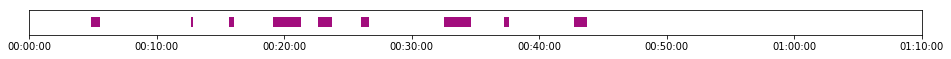

In [1175]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=.5)
make_graph(
    blank_segments[
        (blank_segments['season'] == test_values['season'])
        &(blank_segments['episode'] == test_values['episode'])],
    {
        'start': test_values['limit_start'],
        'end': test_values['limit_end']
    })
plt.gca().axes.get_xaxis().set_visible(True)

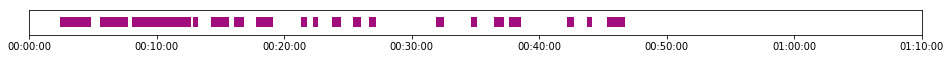

In [1158]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=.5)
make_graph(
    segments[
        (segments['end'] - segments['start'] > pd.Timedelta(seconds=20))
        &(segments['season'] == test_values['season'])
        &(segments['episode'] == test_values['episode'])],
    {
        'start': test_values['limit_start'],
        'end': test_values['limit_end']
    })
plt.gca().axes.get_xaxis().set_visible(True)